# Customer Churn Prediction with PySpark


# 1. Introduction

### Business Context
The data is from a fictitious music streaming service such as Spotify or Pandora. Millions of users play their favorite songs through such services on a daily basis, either through free tier that plays advertisements, or by using a premium subscription model which offers additional functionalities and is typically ad-free. Users can upgrade, downgrade or cancel the plan, so it is very important to make sure the users like the service. 

Every time a user interacts with a music streaming app, whether playing songs, adding them to playlists, rating them with the thumbs down/up, adding a friend, logging in or out, changing settings, data is generated. User activity logs contain key insights for helping the businesses understand whether the users are happy with the service.

In order to stay on track with its (financial) goals, it is key for a music streaming business to identify users that are likely to churn, i.e. users who are at risk of downgrading from premium to free tier, or cancelling the service. If a music streaming business accurately identifies such users in advance, they can offer them discounts or other similar incentives and save millions in revenues. It is a well-known fact that it is more expensive to acquire a new customer than it is to retain an existing one.

### Project Overview
Our goal is to build and train a binary classifier that is able to accurately identify users (in both free and paid tier) who cancelled the Sparkify music streaming service, based on the patterns obtained from their past activity and interaction with the service. A successfully trained model could be used to identify users who are likely to churn in advance.

### Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:
# import libraries

import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
from pyspark.sql.types import IntegerType, DateType, TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator

In [3]:
# create a Spark session
spark = SparkSession \
.builder \
.appName('CustomerChurn') \
.getOrCreate()

In [4]:
# Check Spark configuration
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '192.168.0.32'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '50286'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'CustomerChurn'),
 ('spark.app.id', 'local-1594831286878')]

In [5]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

# 2. Data Understanding
Performing EDA by loading a small subset of the data and doing basic manipulations within Spark. 


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
# Structure of the dataframe
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Column types 
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [8]:
# Obtain the number of distinct users in the smaller Sparkify dataset
# (In the full Sparkify dataset there is 22277 unique users)
df.select(['userId']).dropDuplicates().count()

226

In [9]:
# drop duplicates method would identify inconsistent number of unique users.
df.select(['firstName','gender','lastName','location','registration','userAgent','userId']) \
.where(df.userId != "") \
.dropDuplicates().count()

225

In [10]:
# Number of sessions
df.select("sessionId").dropDuplicates().count()

2354

In [11]:
# There are also no empty strings in the column
df.where(df.sessionId == "").count()

0

In [12]:
#SessionId is a unique identifier only for a specific user. Multiple users can have sessions labelled with the
#same sessionId
df.where(df.userId != "")\
.select(['userId','sessionId']).dropDuplicates()\
.groupby('sessionId').count().sort('count', ascending = False).show(5)

+---------+-----+
|sessionId|count|
+---------+-----+
|      202|    4|
|      113|    4|
|       65|    4|
|      112|    4|
|      167|    4|
+---------+-----+
only showing top 5 rows



In [13]:
# Sessions in the dataset can be very long. The longest lasted 267305 seconds which is more than 74 hours.
session_end = df.where(df.userId != "") \
.groupby(['userId','sessionId']).agg(Fmax('ts').alias('max'), 
                                     Fmin('ts').alias('min'), 
                                     ((Fmax('ts') - Fmin('ts')) / 1000).alias('sessionlength')) \
.sort('sessionlength', ascending = False).show(5)

+------+---------+-------------+-------------+-------------+
|userId|sessionId|          max|          min|sessionlength|
+------+---------+-------------+-------------+-------------+
|    91|     1840|1542852334000|1542585029000|     267305.0|
|   115|      316|1538924417000|1538701498000|     222919.0|
|   101|      635|1539263366000|1539065365000|     198001.0|
|   120|      731|1539793336000|1539630700000|     162636.0|
|    61|      529|1539247693000|1539096212000|     151481.0|
+------+---------+-------------+-------------+-------------+
only showing top 5 rows



In [14]:
# Based on the analysis performed it seems that the maximum time between two consecutive logs that still belong to 
# the same sesssion is one hour. In the provided dataset the maximum interval is 3310 seconds which is around 55 minutes.
windowsession = Window.partitionBy(['userId','sessionId']).orderBy('ts')

df = df.withColumn("previousts", lag(df.ts).over(windowsession))
df = df.withColumn("diff", (df.ts - df.previousts)/1000)
df.where(df.userId != "").agg(Fmax(col('diff'))).show()

+---------+
|max(diff)|
+---------+
|   3310.0|
+---------+



In [15]:
# Number of different artists
df.where(df.artist.isNotNull()).select('artist').dropDuplicates().count()

17655

In [16]:
# There are rows with empty strings in the 'userId' column.
df.where(df.userId == "").count()

8346

In [17]:
# The subscription 'level' variable is rather indepdendent of other variables in the dataset. The users can switch between 
# free and paid tier anytime and is not static. 
df.groupby('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [18]:
# Shape of the smaller Sparkify dataframe
nrows = df.count()
ncols = len(df.dtypes)
print(f'The imported dataframe has {nrows} rows and {ncols} columns.')

The imported dataframe has 286500 rows and 20 columns.


In [19]:
# Print first 5 rows to get the idea of the dataframe; first 11 columns in alphabetical order
df.select(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName','length', 'level', 'location', 'method', 'page']).show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|
|    Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|   PUT|NextSong|
|          Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|   PUT|NextSong|
|       Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|   PUT|NextSong|
+----------------+------

In [20]:
# Print first 5 rows to get the idea of the dataframe; 12.-18. column
df.select(['registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']).show(5)

+-------------+---------+--------------------+------+-------------+--------------------+------+
| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+--------------------+------+-------------+--------------------+------+
|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|    30|
|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|     9|
|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|    30|
+-------------+---------+--------------------+------+-------------+--------------------+------+
only showing top 5 rows



In [21]:
# Explore missing values in the 'userId' column
df.where(df.userId.isNull()).count()

0

### User-level Analysis 

In [22]:
# Logs belonging to a specific user
df.where(df.userId == 4).select(['userId','sessionId','itemInSession','auth','level','page','ts']).show(500)

+------+---------+-------------+---------+-----+---------------+-------------+
|userId|sessionId|itemInSession|     auth|level|           page|           ts|
+------+---------+-------------+---------+-----+---------------+-------------+
|     4|      240|            0|Logged In| free|       NextSong|1538356650000|
|     4|      240|            1|Logged In| free|         Logout|1538356651000|
|     4|      240|            4|Logged In| free|           Home|1538356686000|
|     4|      240|            5|Logged In| free|       NextSong|1538356889000|
|     4|      240|            6|Logged In| free|           Home|1538356954000|
|     4|      240|            7|Logged In| free|       NextSong|1538357110000|
|     4|      240|            8|Logged In| free|       NextSong|1538357328000|
|     4|      240|            9|Logged In| free|       NextSong|1538357543000|
|     4|      240|           10|Logged In| free|       NextSong|1538357746000|
|     4|      240|           11|Logged In| free|    

In [23]:
# Rows with empty string in the 'userId' column correspond to logs in which user has not been logged in
# (either 'Logged Out' or 'Guest' authentication levels). 
df.select(['userId','firstName','gender','lastName',
           'sessionId','location','auth','level','ts','page']).where(df.userId == "").show(10)

df.where(df.userId == "").groupby('auth').count().show()

+------+---------+------+--------+---------+--------+----------+-----+-------------+-----+
|userId|firstName|gender|lastName|sessionId|location|      auth|level|           ts| page|
+------+---------+------+--------+---------+--------+----------+-----+-------------+-----+
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355745000| Home|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355807000| Help|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355841000| Home|
|      |     null|  null|    null|        8|    null|Logged Out| free|1538355842000|Login|
|      |     null|  null|    null|      240|    null|Logged Out| free|1538356678000| Home|
|      |     null|  null|    null|      240|    null|Logged Out| free|1538356679000|Login|
|      |     null|  null|    null|      100|    null|Logged Out| free|1538358102000|Login|
|      |     null|  null|    null|      241|    null|Logged Out| free|1538360117000|Login|

In [24]:
# Explore the auth column
df.groupby('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



In [25]:
#App users dataset
gender_dist = df.select(['userId','gender']).where(df.userId != "").dropDuplicates(['userId']).groupby('gender').count().toPandas()
gender_dist_rel = (gender_dist.set_index('gender') / sum(gender_dist['count']))

#Activity dataset
gender_dist_logs = df.where(df.userId != "").groupby('gender').count().toPandas()
gender_dist_logs_rel = (gender_dist_logs.set_index('gender') / sum(gender_dist_logs['count']))

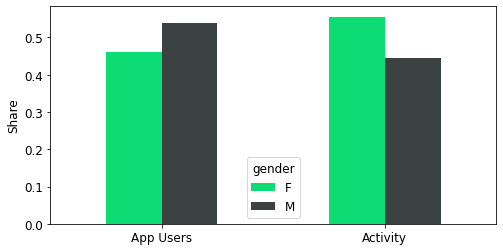

In [26]:
comparison = gender_dist_rel.merge(gender_dist_logs_rel, on='gender')
comparison.columns = ['App Users', 'Activity']

# Define plotting parameters
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 12})

# Define colors to use throughout this notebook
colors = ["tealish green", "charcoal grey"]
palette = sns.xkcd_palette(colors)
color1 = palette[0]
color2 = palette[1]

# Plot
comparison.transpose().plot.bar(rot = 0, color = [color1, color2]);
plt.ylabel('Share');

### Log Features Analysis

In [27]:
# Explore the 'page' column that represents the types of interactions with the music streaming service
# Obtain the distribution of the interaction types in the analyzed dataset
df.groupby('page').count().sort('count', ascending = False).show(22)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
|            Register|    18|
| Submit Registration|     5|
+--------------------+------+



In [28]:
# The smaller dataset is representative - distribution of the interaction types is similar in the full Sparkify dataset
page_pd_full = pd.DataFrame({'page' : ['NextSong','Home','Thumbs Up', 'Add to Playlist', 'Roll Advert', 'Add Friend', 
                                       'Login','Logout', 'Thumbs Down', 'Downgrade', 'Help', 'Settings', 'About', 
                                       'Upgrade', 'Save Settings', 'Error', 'Submit Upgrade', 'Submit Downgrade', 'Cancel',
                                     'Cancellation Confirmation', 'Register', 'Submit Registration'],
                             'count' : [20850272, 1343102, 1151465, 597921, 385212, 381664, 296350, 296005, 239212,
                                    184240, 155100, 147074, 92759, 50507, 29516, 25962, 15135, 6494, 5003, 5003, 802,401]})

page_pd_full['Full Sparkify Dataset'] = page_pd_full['count'] / sum(page_pd_full['count'])

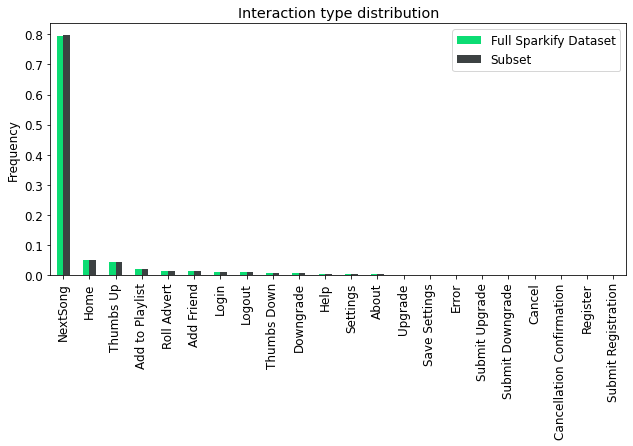

In [29]:
# Visualize the categorical distribution
page_pd = df.groupby('page').count().sort('count', ascending = False).toPandas()
page_pd['Subset'] = page_pd['count'] / sum(page_pd['count'])
# Compare to statistics calculated on gull Sparkify dataset
compare_pd = page_pd_full.merge(page_pd, on = 'page')

# Plot
plt.rcParams['figure.figsize'] = (10,7)
compare_pd.plot(x='page', y= ['Full Sparkify Dataset', 'Subset'], kind = "bar",  color = [color1, color2]);
plt.xlabel("");
plt.ylabel("Frequency");
plt.title("Interaction type distribution");
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.45);
plt.savefig('interactiontype1');

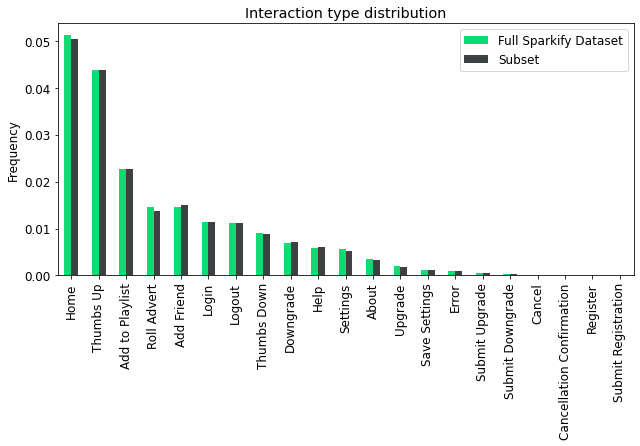

In [30]:
# Distribution ex playing songs
compare_pd[compare_pd['page']!='NextSong'].plot(x='page', y= ['Full Sparkify Dataset', 'Subset'], kind = "bar",
                                               color = [color1, color2]);

# Plot
plt.rcParams['figure.figsize'] = (10,7)
plt.xlabel("");
plt.ylabel("Frequency");
plt.title("Interaction type distribution");
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.45);
plt.savefig('interactiontype2')

# 3. Data transformation
Since both the predictors and the response variable need to be defined at the level of an individual user, we had to first transform the original dataset (one row per log) to a dataset with user-level information or statistics (one row per user), obtained either through mapping (e.g. user's gender, length of observation period, etc.) or aggregation (e.g. activity count). 

### Registration and Observation period

In [31]:
# Convert the timestamps in columns 'registration' and 'ts' into datetime format and add them to the dataframe
df = df.withColumn('registrationDate', (df['registration'] / 1000).cast(TimestampType()))
df = df.withColumn('tsDate', (df['ts'] / 1000).cast(TimestampType()))

In [32]:
# Based on the data shown below it seems the observation period started at 02:01:57, October 1, 2018
df.select('userId', 'page', 'ts', 'tsDate').sort('ts').show(5)

+------+--------+-------------+-------------------+
|userId|    page|           ts|             tsDate|
+------+--------+-------------+-------------------+
|    30|NextSong|1538352117000|2018-10-01 02:01:57|
|     9|NextSong|1538352180000|2018-10-01 02:03:00|
|    30|NextSong|1538352394000|2018-10-01 02:06:34|
|     9|NextSong|1538352416000|2018-10-01 02:06:56|
|    30|NextSong|1538352676000|2018-10-01 02:11:16|
+------+--------+-------------+-------------------+
only showing top 5 rows



In [33]:
# Based on the data shown below it seems the observation period ended at 00:58:40, December 01, 2018 
df.select('userId', 'page', 'ts', 'tsDate').sort('ts', ascending = False).show(10)

+------+---------------+-------------+-------------------+
|userId|           page|           ts|             tsDate|
+------+---------------+-------------+-------------------+
|100002|       NextSong|1543799476000|2018-12-03 02:11:16|
|200008|       NextSong|1543622579000|2018-12-01 01:02:59|
|   152|       NextSong|1543622432000|2018-12-01 01:00:32|
|300011|       NextSong|1543622411000|2018-12-01 01:00:11|
|300011|          About|1543622398000|2018-12-01 00:59:58|
|200008|       NextSong|1543622395000|2018-12-01 00:59:55|
|   138|       NextSong|1543622365000|2018-12-01 00:59:25|
|    39|       NextSong|1543622355000|2018-12-01 00:59:15|
|    30|Add to Playlist|1543622320000|2018-12-01 00:58:40|
|    30|       NextSong|1543622287000|2018-12-01 00:58:07|
+------+---------------+-------------+-------------------+
only showing top 10 rows



In [34]:
# 'Cancelled' category corresponds to 'Cancellation Confirmation' in the page column
df.where(df.auth == 'Cancelled').select(['userId', 'tsDate', 'sessionId', 'auth', 'page']).show(5)

+------+-------------------+---------+---------+--------------------+
|userId|             tsDate|sessionId|     auth|                page|
+------+-------------------+---------+---------+--------------------+
|    18|2018-10-07 22:26:30|      514|Cancelled|Cancellation Conf...|
|    32|2018-10-08 23:10:46|      540|Cancelled|Cancellation Conf...|
|   125|2018-10-12 06:35:18|      174|Cancelled|Cancellation Conf...|
|   105|2018-10-12 22:17:21|      508|Cancelled|Cancellation Conf...|
|    17|2018-10-13 23:19:44|      797|Cancelled|Cancellation Conf...|
+------+-------------------+---------+---------+--------------------+
only showing top 5 rows



In [35]:
# Remove rows with missing userId 
df = df.where(df.userId != "")
df.count()

278154

## Transformations on the Original Dataset

In [36]:
# Default observation start and end timestamps for users who have registered before October 1 and haven't churned
obs_start_default = 1538352000000
obs_end_default = 1543622400000

#### Registration
User's registration dates are listed in the registration column of the imported dataset, but we have observed that they do not always seem to be correct. For users who registered after the start of the default observation period the registration dates are not consistent with the actual log timestamps and activity types. We thus had to obtain late registrations by finding 'Submit Registration' logs in the page column. 

In [37]:
# "Submit registration" events have empty strings in the userId column.
# The userId can be inferred from the sessionId information.
df.select(['userId','auth','page','tsDate','sessionId']).where(df.page == 'Submit Registration').show()

+------+----+----+------+---------+
|userId|auth|page|tsDate|sessionId|
+------+----+----+------+---------+
+------+----+----+------+---------+



In [38]:
# Registration of the userId=154 - note that the time of "Submit Registration" log does not match the 
# registration time printed above.
df.select(['userId','auth','page','tsDate', 'sessionId']).where(df.sessionId == 1506).show(10)

+------+---------+---------------+-------------------+---------+
|userId|     auth|           page|             tsDate|sessionId|
+------+---------+---------------+-------------------+---------+
|   154|Logged In|           Home|2018-11-02 16:15:35|     1506|
|   154|Logged In|       NextSong|2018-11-02 16:15:38|     1506|
|   154|Logged In|       NextSong|2018-11-02 16:18:39|     1506|
|   154|Logged In|       NextSong|2018-11-02 16:22:19|     1506|
|   154|Logged In|       NextSong|2018-11-02 16:26:59|     1506|
|   154|Logged In|       NextSong|2018-11-02 16:32:26|     1506|
|   154|Logged In|    Roll Advert|2018-11-02 16:33:03|     1506|
|   154|Logged In|       NextSong|2018-11-02 16:36:29|     1506|
|   154|Logged In|       NextSong|2018-11-02 16:40:35|     1506|
|   154|Logged In|Add to Playlist|2018-11-02 16:40:46|     1506|
+------+---------+---------------+-------------------+---------+
only showing top 10 rows



As can be seen in the table above, the 'Submit Registration' event is followed by user's first interaction in the same session. To identify users with late registrations we have shifted the page column by one index (within a given session) and checked whether the first entry of the lagged column reads 'Submit Registration'. For each such user the start of the observation period has been set to the timestamp of his/her first log, whereas for all other users the default start time applies.

In [39]:
# Lag the page column
windowsession = Window.partitionBy('sessionId').orderBy('ts')
df = df.withColumn("lagged_page", lag(df.page).over(windowsession))

In [40]:
# With the lagged page column we can identify the users that registered later
df.where(df.lagged_page == "Submit Registration").select(['userId','auth','lagged_page','tsDate', 'sessionId']).show()

+------+----+-----------+------+---------+
|userId|auth|lagged_page|tsDate|sessionId|
+------+----+-----------+------+---------+
+------+----+-----------+------+---------+



In [41]:
# All the values calculated here are the same for all logs belonging to a given user. Nevertheless, we attach them to the
# original dataset, as they are needed for activity trend calculation 
windowuser = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Identify users that registered after the start of observation, and infer the start date accordingly
df = df.withColumn("beforefirstlog", first(col('lagged_page')).over(windowuser))
df = df.withColumn("firstlogtime", first(col('ts')).over(windowuser))
df = df.withColumn("obsstart", 
                   when(df.beforefirstlog == "Submit Registration", df.firstlogtime).otherwise(obs_start_default))

#### Cancellation
Similar to above, there are users who cancelled their service before the end of the default observation period, the so-called churned users. One can simply identify them by finding all the 'Cancellation Confirmation' entries in the page column. For each such user the end of the respective observation period has been set to the timestamp of his/her last log entry, whereas for all other users the default end date applies.

In [42]:
# Identify users that cancelled their service, i.e. users whose last log event is "Cancellation Confirmation", and
# obtain the corresponding end of the observation period. This is done on the original dataset
# so a single value, e.g. end of observation period, is copied to all rows belonging to a given userId.

df = df.withColumn("endstate", last(col('page')).over(windowuser))
df = df.withColumn("lastlogtime", last(col('ts')).over(windowuser))
df = df.withColumn("obsend", when(df.endstate == "Cancellation Confirmation", df.lastlogtime).otherwise(obs_end_default))


#### Relative timing of each log
As mentioned before, we wanted to include activity trend as one of the predictors of churned users. Trend can be estimated by calculating a specific metric on the first and last k days of the observation period and then comparing them. 

In [43]:
# For each log compute the time from the beginning of observation...
df = df.withColumn("timefromstart", col('ts')-col("obsstart"))
# ...and time before the end of observation
df = df.withColumn("timebeforeend", col('obsend')-col('ts'))

In [44]:
# Example of a user with default observation start and earlier observation end due to Cancellation Confirmation
df.select(['userId','obsstart','obsend','endstate','page','ts','timefromstart','timebeforeend'])\
.where(df.userId == 100023).show(5)

+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
|userId|     obsstart|       obsend|            endstate|      page|           ts|timefromstart|timebeforeend|
+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
|100023|1538352000000|1539475237000|Cancellation Conf...|     About|1538665362000|    313362000|    809875000|
|100023|1538352000000|1539475237000|Cancellation Conf...|  NextSong|1538665432000|    313432000|    809805000|
|100023|1538352000000|1539475237000|Cancellation Conf...|Add Friend|1538665433000|    313433000|    809804000|
|100023|1538352000000|1539475237000|Cancellation Conf...|Add Friend|1538665434000|    313434000|    809803000|
|100023|1538352000000|1539475237000|Cancellation Conf...|  NextSong|1538767734000|    415734000|    707503000|
+------+-------------+-------------+--------------------+----------+-------------+-------------+-------------+
o

#### Last Subscription Level
One other operation that we have performed on the original dataset is finding the user's last subscription level (free or paid) at the last log entry, so either user's subscription level at the time of cancellation, or at the end of the default observation period. 

In [45]:
# Obtain user's last subscription level and add it to the original dataset
df = df.withColumn("lastlevel", last(col('level')).over(windowuser))

In [46]:
# Remove rows with corrupted timestamps
df = df.where(df.ts < obs_end_default)
df.count()

278150

### Mapping and Aggregation
As the next step, we have transformed the original Sparkify dataset (one row per log) to a dataset with user-level information or statistics (one row per user), which have been obtained either through mapping from the original dataset (applies to user-level features such as user's gender, last subscription level, etc.) or aggregation (grouping the logs by userId, e.g. total activity count of each user).

The newly created dataset includes the following columns:

userId
* lastlevel : user's last subscription level, transformed into binary format (1 - paid tier, 0 - free tier)
* gender : gender, transformed into binary format (1 - female, 0 - male)
* obsstart, obsend: start and end of the observation period
* endstate : last interaction in the observation period
* nact : user's total number of interactions in the observation period
* nsongs, ntbup, ntbdown, nfriend, nplaylist, ndgrade, nupgrade, nhome, nadvert, nhelp, nsettings, nerror : number of songs played, thumbs up given, thumbs down given, friends added, songs added to playlist, downgrades, upgrades, home page visits, advertisements played, help page visits, settings visits, errors, respectively
* nact_recent, nact_oldest : user's activity in the last and first k days of the observation window, respectively
* nsongs_recent, nsongs_oldest : songs played in the last and first k days of the observation window, respectively

In [47]:
# Length of the estimation window for activity trend calculation
trend_est_days = 14
trend_est_hours = trend_est_days * 24
# In timestamp format
trend_est = trend_est_days * 24 * 60 * 60 * 1000

In [48]:
# Aggregation by userId
df_user = df.groupby('userId')\
.agg(
     # User-level features
     first(when(col('lastlevel') == 'paid', 1).otherwise(0)).alias('lastlevel'),
     first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'),
     first(col('obsstart')).alias('obsstart'),
     first(col('obsend')).alias('obsend'),
     first(col('endstate')).alias('endstate'),
     
     # Aggregated activity statistics
     count(col('page')).alias('nact'),
     Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias("nsongs"),
     Fsum(when(col('page') == "Thumbs Up", 1).otherwise(0)).alias("ntbup"),
     Fsum(when(col('page') == "Thumbs Down", 1).otherwise(0)).alias("ntbdown"),
     Fsum(when(col('page') == "Add Friend", 1).otherwise(0)).alias("nfriend"),
     Fsum(when(col('page') == "Add to Playlist", 1).otherwise(0)).alias("nplaylist"),     
     Fsum(when(col('page') == "Submit Downgrade", 1).otherwise(0)).alias("ndgrade"),
     Fsum(when(col('page') == "Submit Upgrade", 1).otherwise(0)).alias("nugrade"),
     Fsum(when(col('page') == "Home", 1).otherwise(0)).alias("nhome"),
     Fsum(when(col('page') == "Roll Advert", 1).otherwise(0)).alias("nadvert"),
     Fsum(when(col('page') == "Help", 1).otherwise(0)).alias("nhelp"),
     Fsum(when(col('page') == "Settings", 1).otherwise(0)).alias("nsettings"),
     Fsum(when(col('page') == "Error", 1).otherwise(0)).alias("nerror"),
     
     # Aggregated activity statistics in different periods 
     Fsum(when(col('timebeforeend') < trend_est, 1).otherwise(0)).alias("nact_recent"),
     Fsum(when(col('timefromstart') < trend_est, 1).otherwise(0)).alias("nact_oldest"),
     Fsum(when((col('page') == "NextSong") & (col('timebeforeend') < trend_est), 1).otherwise(0)).alias("nsongs_recent"),
     Fsum(when((col('page') == "NextSong") & (col('timefromstart') < trend_est), 1).otherwise(0)).alias("nsongs_oldest") )

In [49]:
# Sample rows in a newly created dataset; user-level features
df_user.select(['userId','gender','lastlevel','obsstart','obsend','endstate']).show(5)

+------+------+---------+-------------+-------------+--------------------+
|userId|gender|lastlevel|     obsstart|       obsend|            endstate|
+------+------+---------+-------------+-------------+--------------------+
|100010|     1|        0|1538352000000|1543622400000|              Logout|
|200002|     0|        1|1538352000000|1543622400000|           Thumbs Up|
|   125|     0|        0|1538352000000|1539318918000|Cancellation Conf...|
|   124|     1|        1|1538352000000|1543622400000|                Home|
|    51|     0|        1|1538352000000|1539761972000|Cancellation Conf...|
+------+------+---------+-------------+-------------+--------------------+
only showing top 5 rows



In [50]:
# Sample rows in a newly created dataset; aggregated activity statistics
df_user.select(['userId','nact','nsongs','ntbup','ntbdown','nfriend','nplaylist',
                'ndgrade','nugrade','nhome','nadvert','nhelp','nsettings','nerror']).show(5)

+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
|userId|nact|nsongs|ntbup|ntbdown|nfriend|nplaylist|ndgrade|nugrade|nhome|nadvert|nhelp|nsettings|nerror|
+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
|100010| 381|   275|   17|      5|      4|        7|      0|      0|   11|     52|    2|        0|     0|
|200002| 474|   387|   21|      6|      4|        8|      0|      1|   20|      7|    2|        3|     0|
|   125|  11|     8|    0|      0|      0|        0|      0|      0|    0|      1|    0|        0|     0|
|    51|2464|  2111|  100|     21|     28|       52|      0|      0|   75|      0|   12|       12|     1|
|   124|4825|  4079|  171|     41|     74|      118|      0|      0|  176|      4|   23|       20|     6|
+------+----+------+-----+-------+-------+---------+-------+-------+-----+-------+-----+---------+------+
only showing top 5 rows



In [51]:
# Sample rows in a newly created dataset; aggregated activity statistics in different periods
df_user.select(['userId','nact_recent','nact_oldest','nsongs_recent','nsongs_oldest']).show(5)

+------+-----------+-----------+-------------+-------------+
|userId|nact_recent|nact_oldest|nsongs_recent|nsongs_oldest|
+------+-----------+-----------+-------------+-------------+
|100010|         33|         40|           24|           31|
|200002|          0|         37|            0|           24|
|   125|         11|         11|            8|            8|
|   124|        509|       1093|          440|          921|
|    51|       1865|       2052|         1614|         1757|
+------+-----------+-----------+-------------+-------------+
only showing top 5 rows



# 4. Feature Engineering
By using the mappings and aggregated statistics expressed at the level of an individual user we could then finally construct the features that in our opinion contain key insights for identifying churned users. 

**Note**: When defining predictor variables one needs to make sure that they do not contain any information that would not be available if running a model on an unlabelled dataset. For example, in the original log dataset churned users typically have significantly shorter observation periods, therefore, total activity count would not be an appropriate predictor, as it contains indirect information about the response variable, which we would not have if the data was unlabelled. For this reason, all the features need to be expressed either per unit of time or in relation to another variable measured over the same observation period. However, since the relative statistics for different users are measured on sometimes inconsistent observation periods, one needs to assume that the underlying data distributions in the 2-month window do not change due to some exogenous variable (but only due to the users themselves - which is measured in the activity trend feature defined below).

### Numerical Features
We have constructed several numerical features that in our opinion capture well the patterns in user's past activity and interaction with the music streaming service, and could be used to identify churned users:

#### Aggregated statistics per hour

- ***nact_perh*** : user's number of interactions per hour, calculated as $$nact\_perh = \frac{nact}{obshours},$$ where _nact_ represents the user's total number of interactions and _obshours_ the length of the user-specific observation period in hours;


- ***nsongs_perh, ntbup_perh, ntbdown_perh, nfriend_perh, nplaylist_perh, nhome_perh, nadvert_perh, nhelp_perh, nerror_perh*** : songs played per hour, thumbs up per hour, thumbs down per hour, friends added per hour, songs added to playlist per hour, home page visits per hour, advertisements played per hour, help page visits per hour, errors per hour (all calculated in the same way as *nact_perh* above);

#### Activity type ratios

- ***songratio*** : number of songs played relative to all user interactions, calculated as $$songratio = \frac{nsongs}{nact}$$


- ***positiveratio*** : number of positive interactions relative to all user interactions, calculated as $$positiveratio = \frac{ntbup + nfriend + nplaylist}{nact},$$ where _ntbup_, _nfriend_ and _nplaylist_ represent number of thumbs up given, friends added and songs added to playlist, respectively;


- ***negativeratio*** : number of negative or non-pleasant interactions relative to all interactions, calculated as $$negativeratio = \frac{ntbdown + nhelp + nerror+ nsettings}{nact},$$ where _ntbdown_, _nhelp_,  _nerror_ and _nsettings_ represent number of thumbs down given, help page visits, errors and settings page visits, respectively;


- ***updownratio*** : ratio between the number of thumbs up and thumbs down given $$updownratio = \frac{ntbup}{ntbdown+0.1}$$


- ***upgradedowngrade*** : total number of subscription plan changes, calculated as $$upgradedowngrade = nugrade + ndgrade,$$ where _nugrade_ is the number of upgrades from free to paid plan and _ndgrade_ downgrades from paid to free plan;

#### Trend features

- ***trend_act*** : user's activity trend, calculated as $$trend\_act = \frac{nact\_recent(k) - nact\_oldest(k)}{k \times obshours},$$
where *nact_recent(k)* and *nact_oldest(k)* represent the number of interactions the user had with the service in the last and first _k_ days (default k = 14) of the observation window, respectively (the difference in activity is also scaled with the length of the observation window);


- ***trend_songs*** : user's song playing trend, calculated as $$trend\_songs = \frac{nsongs\_recent(k) - nsongs\_oldest(k)}{k \times obshours},$$
where *nsongs_recent(k)* and *nsongs_oldest(k)* count how many songs the user played in the last and first _k_ days (default k = 14) of the observation window, respectively (the difference in activity is scaled with the length of the observation window);

#### Interaction patterns

In addition to the features that are built on aggregated statistics measured throughout the observation period, we have also included three extra features that reflect user's interaction patterns:

- ***avgsessionitems*** : user's average number of interactions in a given session (to recall, two consecutive logs belong to the same session if there is less than one hour between them);


- ***avgsessiontime*** : user's average session length;



- ***avgsongs*** : user's average number of songs played between two consecutive home page visits




### Categorical Features
In addition to all the above-defined features, we have decided to use two **categorical** user-level features in the model: user's ***gender*** and user's last subscription level stored in the ***lastlevel*** variable. Both have been obtained already in the step above, so no further data transformations were needed.

In [52]:
# Calculation of the defined features that will be used for identifying churned users
# The first added column, 'obshours', represents the length of the user-specific observation period in hours. The column 
# is not one of the features but is used to calculate all aggregated statistics per hour
df_user = df_user.withColumn('obshours', (col('obsend') - col('obsstart'))/1000/3600)\
.withColumn('nact_perh', col('nact') / col('obshours'))\
.withColumn('nsongs_perh', col('nsongs') / col('obshours'))\
.withColumn('ntbup_perh', col('ntbup') / col('obshours'))\
.withColumn('ntbdown_perh', col('ntbdown') / col('obshours'))\
.withColumn('nfriend_perh', col('nfriend') / col('obshours'))\
.withColumn('nplaylist_perh', col('nplaylist') / col('obshours'))\
.withColumn('nhome_perh', col('nhome') / col('obshours'))\
.withColumn('nadvert_perh', col('nadvert') / col('obshours'))\
.withColumn('nerror_perh', col('nerror') / col('obshours'))\
.withColumn('upgradedowngrade', col('nugrade') + col('ndgrade'))\
.withColumn('songratio', col('nsongs') / col('nact'))\
.withColumn('positiveratio', (col('ntbup') + col('nfriend') + col('nplaylist')) / col('nact'))\
.withColumn('negativeratio', (col('ntbdown') + col('nhelp') + col('nerror') + col('nsettings')) / col('nact'))\
.withColumn('updownratio', col('ntbup') / (col('ntbdown') + 0.1))\
.withColumn('nact_recent_perh', col('nact_recent') / trend_est_hours)\
.withColumn('nact_oldest_perh', col('nact_oldest') / trend_est_hours)\
.withColumn('nsongs_recent_perh', col('nsongs_recent') / trend_est_hours)\
.withColumn('nsongs_oldest_perh', col('nsongs_oldest') / trend_est_hours)\
.withColumn('trend_act', (col('nact_recent_perh') - col('nact_oldest_perh')) / col('obshours'))\
.withColumn('trend_songs', (col('nsongs_recent_perh') - col('nsongs_oldest_perh')) / col('obshours'))

In [53]:
# Engineered features - aggregated statistics per hour
df_user.select(['userId','nact_perh','nsongs_perh', 'ntbup_perh','ntbdown_perh','nfriend_perh']).show(5)

+------+--------------------+-------------------+--------------------+--------------------+--------------------+
|userId|           nact_perh|        nsongs_perh|          ntbup_perh|        ntbdown_perh|        nfriend_perh|
+------+--------------------+-------------------+--------------------+--------------------+--------------------+
|100010| 0.26024590163934425| 0.1878415300546448|0.011612021857923498|0.003415300546448...| 0.00273224043715847|
|200002|  0.3237704918032787|0.26434426229508196|0.014344262295081968|0.004098360655737705| 0.00273224043715847|
|   125|0.040954868975445695| 0.0297853592548696|                 0.0|                 0.0|                 0.0|
|   124|   3.295765027322404|   2.78620218579235|  0.1168032786885246|0.028005464480874317|0.050546448087431695|
|    51|   6.291188761195258|  5.389894267403892|   0.255324219204353|0.053618086032914125| 0.07149078137721884|
+------+--------------------+-------------------+--------------------+--------------------+-----

In [54]:
# Engineered features - activity type ratios
df_user.select(['userId', 'upgradedowngrade', 'songratio', 'positiveratio', 'negativeratio', 'updownratio']).show(5)

+------+----------------+------------------+-------------------+--------------------+------------------+
|userId|upgradedowngrade|         songratio|      positiveratio|       negativeratio|       updownratio|
+------+----------------+------------------+-------------------+--------------------+------------------+
|100010|               0|0.7217847769028871|0.07349081364829396| 0.01837270341207349|3.3333333333333335|
|200002|               1|0.8164556962025317|0.06962025316455696|0.023206751054852322|3.4426229508196724|
|   125|               0|0.7272727272727273|                0.0|                 0.0|               0.0|
|    51|               0| 0.856737012987013|0.07305194805194805|0.018668831168831168| 4.739336492890995|
|   124|               0|0.8453886010362694|0.07523316062176166| 0.01865284974093264| 4.160583941605839|
+------+----------------+------------------+-------------------+--------------------+------------------+
only showing top 5 rows



In [55]:
# Engineered features - trend features
df_user.select(['userId', 'trend_act', 'trend_songs']).show(5)

+------+--------------------+--------------------+
|userId|           trend_act|         trend_songs|
+------+--------------------+--------------------+
|100010|-1.42304189435336...|-1.42304189435337...|
|200002|-7.52179287015352...|-4.87900078064012...|
|   125|                 0.0|                 0.0|
|   124|-0.00118722352328...|-9.77833073119958...|
|    51|-0.00142100086283...|-0.00108664771863...|
+------+--------------------+--------------------+
only showing top 5 rows



In [56]:
# Calculation of user's average number of items per session
session_avgnitems = df.groupby(['userId', 'sessionId'])\
.agg(Fmax(col('itemInSession')).alias('nitems'))\
.groupby('userId').agg(avg(col('nitems')).alias('avgsessionitems'))


# Calculation of user's average session length
session_avglength = df.groupby(['userId', 'sessionId'])\
.agg(Fmin(col('ts')).alias('startsession'), Fmax(col('ts')).alias('endsession'))\
.groupby('userId').agg(avg(col('endsession')-col('startsession')).alias('avgsessionlength'))


# Calculations to obtain user's average number of songs played between consecutive home visits
windowhome = (Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, 0))
df = df.withColumn("phasehome", Fsum(when(df.page == "Home", 1).otherwise(0)).over(windowhome))

songs_home = df.groupby(['userId', 'phasehome'])\
.agg(Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias('total'))\
.groupby('userId').agg(avg(col('total')).alias('avgsongs'))


# Adding the extra features to the df_user dataset with all other engineered features
df_user = df_user\
.join(session_avgnitems, on = 'userId')\
.join(session_avglength, on = 'userId')\
.join(songs_home, on = 'userId')


# Engineered features - user's activity patterns
df_user.select(['userId', 'avgsessionitems', 'avgsessionlength', 'avgsongs']).show(5)

+------+------------------+--------------------+------------------+
|userId|   avgsessionitems|    avgsessionlength|          avgsongs|
+------+------------------+--------------------+------------------+
|100010| 54.42857142857143|           9269000.0|22.916666666666668|
|200002|              80.0|            1.5984E7|18.428571428571427|
|   125|              10.0|           1774000.0|               8.0|
|   124|170.13793103448276|3.4739655172413796E7|23.176136363636363|
|    51|             251.9|           5.23414E7| 28.14666666666667|
+------+------------------+--------------------+------------------+
only showing top 5 rows



### Define Churn


label : binary response variable, where:

* 1 represents churned users who cancelled the subscription (irrespective of the subscription plan, free or paid) within the observation period between October 1 and November 30;
* 0 represents users who kept the music streaming service throughout the observation period

In [57]:
# Calculating the binary response variable
df_user = df_user.withColumn('label', when(df_user.endstate == "Cancellation Confirmation", 1).otherwise(0))

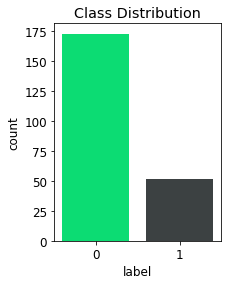

In [58]:
# Distribution of the binary response variable in the analyzed dataset
label_pd = df_user.groupby('label').count().toPandas()

# Plot
plt.rcParams['figure.figsize'] = (3,4)
sns.barplot(x='label', y = 'count', data = label_pd, palette = palette, saturation = 1);
plt.title('Class Distribution');

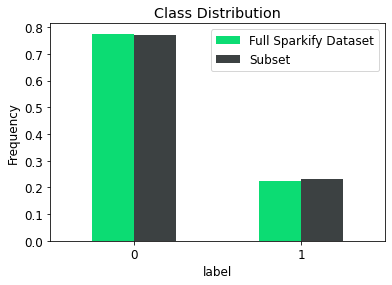

In [59]:
# Similar ratio also on the full Sparkify dataset 
# Copied from notebook used on the CLUSTER:  [5003, 17274]
label_pd['Subset'] = label_pd['count'] / sum(label_pd['count'])
label_pd['count_full'] = [5003, 17274]
label_pd = label_pd.sort_values('label')
label_pd['Full Sparkify Dataset'] = label_pd['count_full'] / sum(label_pd['count_full'])

# Plot
plt.rcParams['figure.figsize'] = (6,4)
label_pd.plot(x='label', y= ['Full Sparkify Dataset', 'Subset'], kind = 'bar', rot = 0, color = [color1, color2]);
plt.ylabel('Frequency');
plt.title('Class Distribution');
plt.savefig('classdist.png')

In [60]:
# Final schema of the transformed dataset
df_user.printSchema()

root
 |-- userId: string (nullable = true)
 |-- lastlevel: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- obsstart: long (nullable = true)
 |-- obsend: long (nullable = true)
 |-- endstate: string (nullable = true)
 |-- nact: long (nullable = false)
 |-- nsongs: long (nullable = true)
 |-- ntbup: long (nullable = true)
 |-- ntbdown: long (nullable = true)
 |-- nfriend: long (nullable = true)
 |-- nplaylist: long (nullable = true)
 |-- ndgrade: long (nullable = true)
 |-- nugrade: long (nullable = true)
 |-- nhome: long (nullable = true)
 |-- nadvert: long (nullable = true)
 |-- nhelp: long (nullable = true)
 |-- nsettings: long (nullable = true)
 |-- nerror: long (nullable = true)
 |-- nact_recent: long (nullable = true)
 |-- nact_oldest: long (nullable = true)
 |-- nsongs_recent: long (nullable = true)
 |-- nsongs_oldest: long (nullable = true)
 |-- obshours: double (nullable = true)
 |-- nact_perh: double (nullable = true)
 |-- nsongs_perh: double (nullable = t

# 5. Exploratory Data Analysis
After completing the feature engineering step we have analyzed the correlations between the built features, and performed also a brief exploratory data analysis with visualizations to inspect how the features relate to the binary response.

In [61]:
# For visualization purposes we switch to pandas dataframes
df_user_pd = df_user.toPandas()

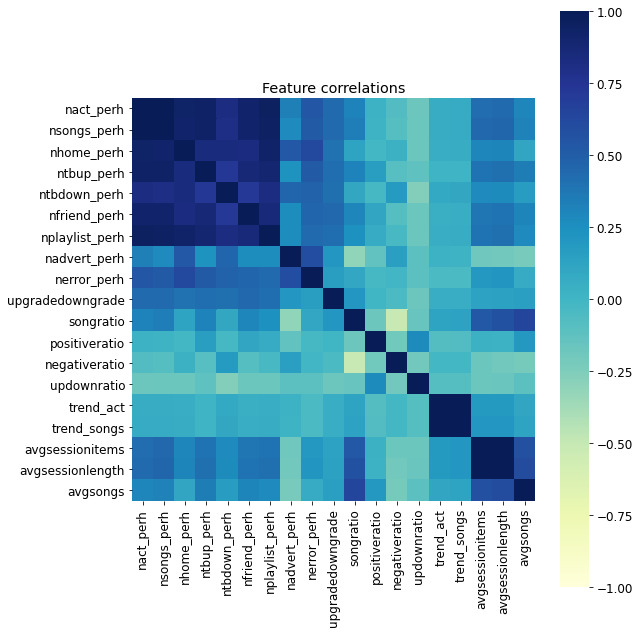

In [62]:
# Calculate correlations between numerical features
cormat = df_user_pd[['nact_perh','nsongs_perh', 'nhome_perh', 'ntbup_perh','ntbdown_perh', 'nfriend_perh','nplaylist_perh', 
'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 'songratio', 'positiveratio','negativeratio', 
'updownratio', 'trend_act', 'trend_songs', 'avgsessionitems',  'avgsessionlength','avgsongs']].corr()

# Plot correlations
plt.rcParams['figure.figsize'] = (10,10)
plt.subplots_adjust(left=0.20, right=0.9, top=0.95, bottom=0.15)
sns.heatmap(cormat, cmap = "YlGnBu", square = True, vmin = -1, vmax = 1);
plt.title('Feature correlations');
plt.savefig('correlations.png')

#### Exploratory Data Analysis
For each engineered feature (except the ones removed in the step above) we have analyzed its relationship with the binary response variable. This was done by comparing the feature distributions between users who churned and users who kept the service. From the visualizations presented below the following _stylized_ observations have been made:
- on average churned users played more songs per hour;
- churned users gave significantly more thumbs down per hour, and had to watch more advertisements on average;
- the ratio of songs and positive interactions relative to total activity was typically lower for churned users
- churned users had on average less interactions per session
- churn rate is higher for users in the free subscription plan
- churn rate is slightly higher for male users
 
No features have been removed based on this analysis.

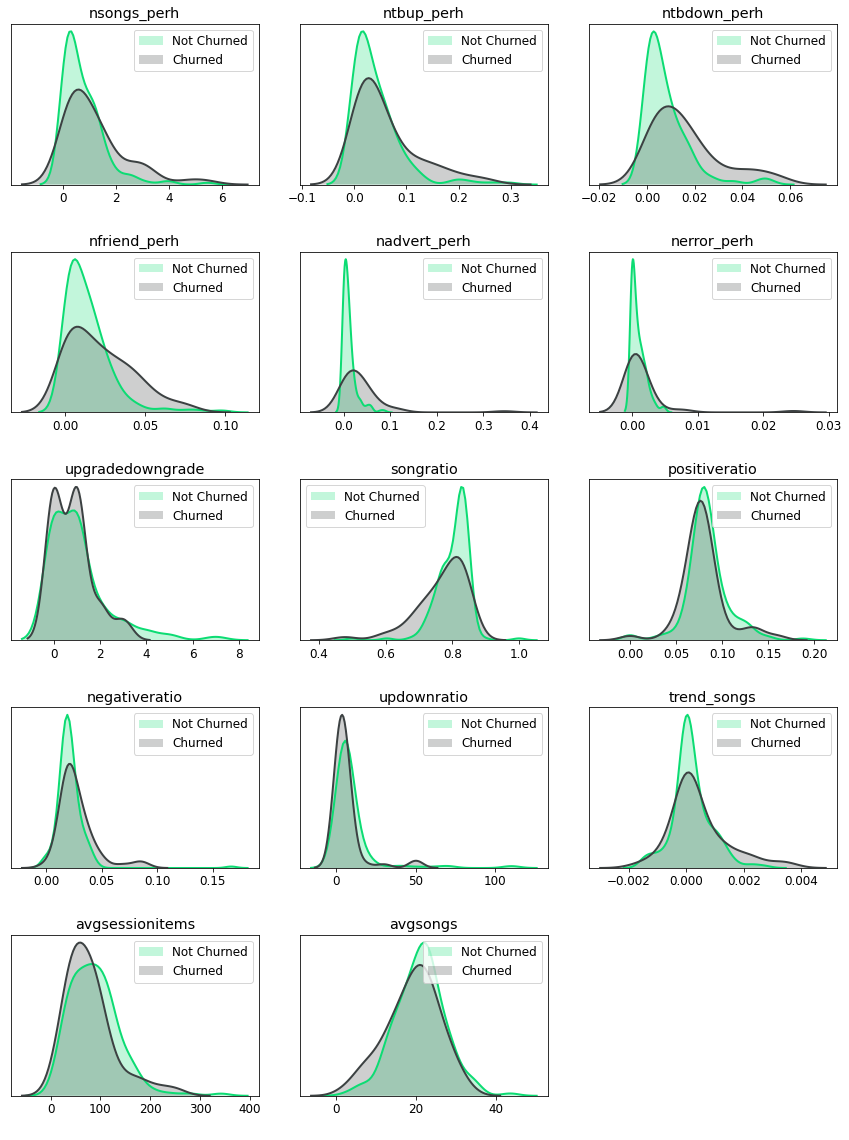

In [63]:
# Plotting the relationship between each numerical feature and binary response

# Numerical features
col = ['nsongs_perh', 'ntbup_perh', 'ntbdown_perh', 
       'nfriend_perh', 'nadvert_perh', 'nerror_perh',
       'upgradedowngrade', 'songratio', 'positiveratio',
       'negativeratio', 'updownratio', 'trend_songs', 
       'avgsessionitems','avgsongs']

plt.rcParams['figure.figsize'] = (12,16)
for i in range(len(col)):
    plt.subplot(5,3,i+1)
    plt.tight_layout();
    sns.distplot(df_user_pd[df_user_pd['label'] == 0][col[i]], hist = False, norm_hist = True, 
                 kde_kws = {'shade': True, 'linewidth': 2}, color = color1);
    sns.distplot(df_user_pd[df_user_pd['label'] == 1][col[i]], hist = False, norm_hist = True, 
                 kde_kws = {'shade': True, 'linewidth': 2}, color = color2);
    plt.legend(['Not Churned','Churned']);
    plt.title(col[i]);
    plt.xlabel(" ");
    plt.yticks([]);
    plt.savefig('exploratory.png')

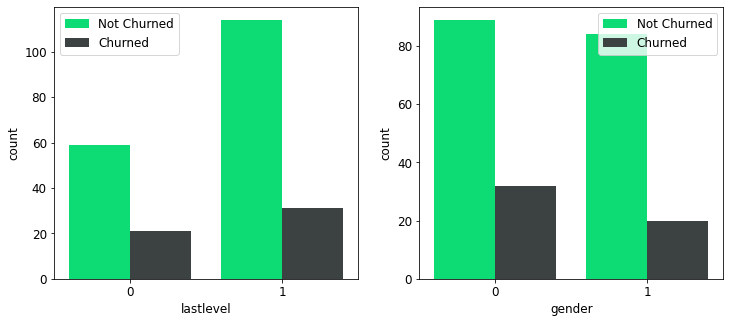

In [64]:
# Analyzing the relationship between categorical features and binary response
# From the visualization we can infer the difference in churn rates between categories of each feature
plt.rcParams['figure.figsize'] = (12,5)

# Last subscription level vs label
plt.subplot(1,2,1)
sns.countplot(x = 'lastlevel', data = df_user_pd, hue = 'label', palette = palette, saturation = 1);
plt.legend(['Not Churned', 'Churned']);

# Gender vs label
plt.subplot(1,2,2)
sns.countplot(x = 'gender', data = df_user_pd, hue = 'label', palette = palette, saturation = 1);
plt.legend(['Not Churned', 'Churned']);

plt.savefig('catexploratory')

# 6. Modeling and Evaluation

We have used Spark's machine learning capabilities to build pipelines that first standardize and combine the engineered features, and then fit one of the Spark-supported binary classifiers. We have performed grid search with cross validation to test several parameter combinations for different classifiers, using the smaller Sparkify dataset in Spark local model. Based on the performance results obtained in cross validation (measured by F1 Score), we have then selected models with best parameter combinations and retrained them on the entire training set. Ultimately, we have evaluated their performance on the test set, using standard binary classification metrics, such as F1 score.


Pipelines

We have first built three different ***Pipeline*** objects for three binary classifiers supported in Spark: **Logistic Regression**, **Random Forest Classifier** and **Gradient-Boosted Tree Classifier**. To recall, the input feature dataset consists of:
- **14 numerical features** (some of the engineered features were removed in the correlation analysis), namely *nsongs_perh*, *ntbup_perh*, *ntbdown_perh*, *nfriend_perh*, *nadvert_perh*, *nerror_perh*, *upgradedowngrade*, *songratio*, *positiveratio*, *negativeratio*, *updownratio*, *trend_songs*, *avgsessionitems*, *avgsongs* (see descriptions in 3.3.)
- **2 binary features**, *lastlevel* and *gender*

Each pipeline combines the following three objects:
1. ***StandardScaler*** that standardizes the numerical features
2. ***VectorAssembler*** that combines them with binary features (already transformed to 0/1 thus no additional transformations are needed)
3. selected **binary classifier** with default parameters (parameters will anyway be passed during grid search)

In [65]:
numeric_columns = ['nsongs_perh', 'ntbup_perh','ntbdown_perh', 'nfriend_perh', 
'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 'songratio', 'positiveratio','negativeratio', 
'updownratio', 'trend_songs', 'avgsessionitems','avgsongs']

# Combining multiple numerical features using VectorAssembler
numeric_assembler = VectorAssembler(inputCols = numeric_columns, outputCol = "numericvectorized")

# Standardizing numerical features
scaler = StandardScaler(inputCol = "numericvectorized", outputCol = "numericscaled", withStd = True, withMean = True)

# Adding the two binary features
binary_columns = ['lastlevel', 'gender']
total_assembler = VectorAssembler(inputCols = binary_columns + ["numericscaled"], outputCol = "features")

# Defining three different pipelines with three different classifiers, all with default parameters
# Logistic regression 
lr =  LogisticRegression()
pipeline_lr = Pipeline(stages = [numeric_assembler, scaler, total_assembler, lr])

# Random forest classifier
rf = RandomForestClassifier()
pipeline_rf = Pipeline(stages = [numeric_assembler, scaler, total_assembler, rf])

# Gradient-boosted tree classifier
gb = GBTClassifier()
pipeline_gb = Pipeline(stages = [numeric_assembler, scaler, total_assembler, gb])

4.2 Grid Search Objects
We have then defined PySpark's grid search objects, namely ***CrossValidator*** objects, that are used to test several parameter combinations for different classifiers, using cross validation. In order to reduce computation times we have only focused on tuning the most prominent parameters of each classifier. The tested parameter values are presented in brackets in the list below.

**a) Logistic Regression**
- ***maxIter*** (maximum number of iterations, default=100) : **[10, 30]**
- ***regParam*** (regularization parameter, default=0.0) : **[0.0, 0.1]**
- ***elasticNetParam*** (mixing parameter - 0 for L2 penalty, 1 for L1 penalty, default=0.0) : **[0.0, 0.5]**

**b) Random Forest Classifier**
- ***maxDepth*** (maximum tree depth, default=5) : **[4, 5, 6, 7]** 
- ***numTrees*** (number of trees, default=20) : **[20, 40]**

**c) Gradient-Boosted Tree Classifier**
- ***maxDepth*** (maximum tree depth, default=5) : **[4, 5]**
- ***maxIter*** (maximum number of iterations, default=20) : **[20, 100]**


In our definition of the grid search objects the performance of each parameter combination is measured the **F1 score** as an custom cross validation evaluator. 

In [66]:
#Custom F1 score evaluator that we can use instead of BinaryClassificationEvaluator() in grid search
class F1score(Evaluator):

    def __init__(self, predictionCol = "prediction", labelCol="label"):
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        
        # Calculate F1 score 
        tp = dataset.where((dataset.label == 1) & (dataset.prediction == 1)).count()
        fp = dataset.where((dataset.label == 0) & (dataset.prediction == 1)).count()
        tn = dataset.where((dataset.label == 0) & (dataset.prediction == 0)).count()
        fn = dataset.where((dataset.label == 1) & (dataset.prediction == 0)).count()
        
        # Add epsilon to prevent division by zero
        precision = tp / (tp + fp + 0.00001)
        recall = tp / (tp + fn + 0.00001)
        
        f1 = 2 * precision * recall / (precision + recall + 0.00001)
        
        return f1

    def isLargerBetter(self):
        return True

In [67]:
# Logistic regression grid search

# Parameter combinations
paramGrid_lr = ParamGridBuilder()\
.addGrid(lr.maxIter, [10, 30]) \
.addGrid(lr.regParam, [0.0, 0.1]) \
.addGrid(lr.elasticNetParam, [0.0, 0.5]) \
.build()

# Grid search with cross validation
crossval_lr = CrossValidator(estimator = pipeline_lr,
                          estimatorParamMaps = paramGrid_lr,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

In [68]:
# Random forest classifier grid search

# Parameter combinations
paramGrid_rf = ParamGridBuilder() \
.addGrid(rf.maxDepth, [4, 5, 6, 7]) \
.addGrid(rf.numTrees, [20, 40]) \
.build()

# Grid search with cross validation
crossval_rf = CrossValidator(estimator = pipeline_rf,
                          estimatorParamMaps = paramGrid_rf,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

In [69]:
# Gradient-boosted tree classifier grid search

# Parameter combinations
paramGrid_gb = ParamGridBuilder() \
.addGrid(gb.maxDepth, [4, 5]) \
.addGrid(gb.maxIter, [20, 100]) \
.build()

# Grid search with cross validation
crossval_gb = CrossValidator(estimator = pipeline_gb,
                          estimatorParamMaps = paramGrid_gb,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

## Training/Test Data Split
The input dataset has been split into training and test set using the **80/20** ratio. During the model tuning the training set is used in 4-fold cross validation so it is further split into multiple training and validation folds.

In [70]:
# Split the data into training (plus validation) and test set 

train_plus_val, test = df_user.randomSplit([0.8, 0.2], seed = 9) 
ntotal = df_user.count()
ntrainval = train_plus_val.count()
ntest = test.count()

print(f'Original dataset: {ntotal} rows. Training and validation: {ntrainval} rows. Testing set: {ntest} rows')

Original dataset: 225 rows. Training and validation: 184 rows. Testing set: 41 rows


#### Model Training and Evaluation

For each defined binary classifier/pipeline we have carried out the following steps:
1. perform grid search with 4-fold cross validation by fitting the defined _CrossValidator_ object on the training data
2. identify the parameter combinations that return the best F1 score in cross validation
3. retrain the best model instance/pipeline on the entire training set
4. if applicable, analyze feature importances
5. evaluate the selected model instance on the test set using **F1** score metric


#### Performance Metrics

**AUC** is a standard binary classification metric that works well for imbalanced datasets. By using AUC one does not need to worry about where to set the probability threshold that translates the model output probabilities into positive and negative class predictions, since AUC summarizes model's performance over all possible thresholds. This works well in a research environment, but not so much if trying to deploy the model in production, as there needs to be an exact threshold in place to interpret the prediction probabilities.

**F1 score** seems even a better choice for measuring the performance of the implemented binary classifier on a given problem, in which we are working with an imbalanced dataset, and where a strong focus needs to be put on the accurate prediction of the positive class representing churned users. As a music streaming service we want to identify most of the users that are likely to churn (aiming for high recall), but at the same time do not want to give too many discounts and incentives to stay for no reason (aiming for high precision), i.e. to users who are actually happy with the service (false positives), as this can have significant financial implications too. 

## Grid Search Tuning Process

### Logistic Regression

In [71]:
# Perform the grid search by fitting the grid search object
start = time.time()
crossvalmodel_lr = crossval_lr.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {round(end-start)} seconds')

# Store grid search results in a dataframe
scores = crossvalmodel_lr.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_lr.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['AUC score'] = scores
params_pd

Time spent for grid search: 367 seconds


,maxIter,regParam,elasticNetParam,AUC score
0,10,0.0,0.0,0.792682
1,10,0.0,0.5,0.792682
2,10,0.1,0.0,0.816353
3,10,0.1,0.5,0.748141
4,30,0.0,0.0,0.796390
5,30,0.0,0.5,0.796390
6,30,0.1,0.0,0.816353
7,30,0.1,0.5,0.748141


In [72]:
# Retrain the classifier with the best performing parameters
best_lr =  LogisticRegression(maxIter = 10, regParam = 0.0)
pipeline_best_lr = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_lr])

start = time.time()
model_lr = pipeline_best_lr.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {round(end-start)} seconds')

Time spent for training: 24 seconds


In [74]:
# Obtain predictions on the test set
results_lr = model_lr.transform(test)
results_lr.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|    51|    1|[-1.2024468168135...|[0.23104022741089...|       1.0|
|   155|    0|[4.40301849884877...|[0.98790767745676...|       0.0|
|100021|    1|[-0.1753936820462...|[0.45626364363306...|       1.0|
|    64|    0|[3.39877755604175...|[0.96766630906047...|       0.0|
|     3|    1|[1.27649919792672...|[0.78185327324561...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [75]:
# F1 score on the test set
f1_evaluator = F1score()
f1score_lr = f1_evaluator._evaluate(results_lr)
print(f'Logistic regression F1 score: {f1score_lr}')

Logistic regression F1 score: 0.47058352944705867


### Random Forest Classifier

In [76]:
# Perform the grid search by fitting the grid search object
start = time.time()
crossvalmodel_rf = crossval_rf.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {round(end-start)} seconds')

Time spent for grid search: 482 seconds


In [77]:
# Store grid search results in a dataframe
scores = crossvalmodel_rf.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_rf.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = scores
params_pd

,maxDepth,numTrees,score
0,4,20,0.822112
1,4,40,0.826952
2,5,20,0.824946
3,5,40,0.834683
4,6,20,0.834331
5,6,40,0.841300
6,7,20,0.827938
7,7,40,0.844348


In [78]:
# Retrain the classifier with the best performing parameters
best_rf =  RandomForestClassifier(maxDepth = 4, numTrees = 40)
pipeline_best_rf = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_rf])

start = time.time()
model_rf = pipeline_best_rf.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {round(end-start)} seconds')

Time spent for training: 47 seconds


In [79]:
# Display feature importances
importances = model_rf.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_columns + numeric_columns
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
6,nadvert_perh,0.189893
4,ntbdown_perh,0.108791
12,updownratio,0.100273
5,nfriend_perh,0.076229
13,trend_songs,0.075818
9,songratio,0.069321
2,nsongs_perh,0.062575
10,positiveratio,0.056233
14,avgsessionitems,0.051995
11,negativeratio,0.049567


In [80]:
# Obtain predictions on the test set
results_rf = model_rf.transform(test)

In [81]:
# F1 score on the test set
f1_evaluator = F1score()
f1score_rf = f1_evaluator._evaluate(results_rf)
print(f'Random forest classifier F1 score: {f1score_rf}')

Random forest classifier F1 score: 0.2857114285857143


### Gradient-boosted Tree Classifier

In [82]:
# Perform the grid search by fitting the grid search object
start = time.time()

crossvalmodel_gb = crossval_gb.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {round(end-start)} seconds')

Time spent for grid search: 3083 seconds


In [83]:
# Store grid search results in a dataframe
scores = crossvalmodel_gb.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_gb.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = scores
params_pd

,maxDepth,maxIter,score
0,4,20,0.798041
1,4,100,0.816997
2,5,20,0.807705
3,5,100,0.799960


In [84]:
# Retrain the classifier with the best performing parameters
best_gb =  GBTClassifier(maxDepth = 5, maxIter = 100)
pipeline_best_gb = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_gb])

start = time.time()
model_gb = pipeline_best_gb.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {round(end-start)} seconds')

Time spent for training: 342 seconds


In [85]:
# Display feature importances
importances = model_gb.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_columns + numeric_columns
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
6,nadvert_perh,0.174519
5,nfriend_perh,0.121671
9,songratio,0.100203
14,avgsessionitems,0.094809
13,trend_songs,0.087311
15,avgsongs,0.068049
4,ntbdown_perh,0.056891
2,nsongs_perh,0.053194
7,nerror_perh,0.051508
3,ntbup_perh,0.049745


In [86]:
# Obtain predictions on the test set
results_gb = model_gb.transform(test)
results_gb.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|    51|    1|[-0.2950175528082...|[0.35662679948756...|       1.0|
|   155|    0|[2.20915625851128...|[0.98808902454165...|       0.0|
|100021|    1|[1.24976840357803...|[0.92410934205890...|       0.0|
|    64|    0|[1.67923739774282...|[0.96638126031305...|       0.0|
|     3|    1|[1.92319344034462...|[0.97908981216729...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [87]:
# F1 score on the test set
f1_evaluator = F1score()
f1score_gb = f1_evaluator._evaluate(results_gb)
print(f'Gradient-boosted tree classifier F1 score: {f1score_gb}')

Gradient-boosted tree classifier F1 score: 0.47058352944705867


## Results Summary

We have ultimately trained and tested three different models, one per each classifier type. The results obtained on the test set are summarized in the table below.

|Classifier                        | Parameters              |  F1   |
| :------------------------------- | :---------------------- |-------|
|Logistic Regression               | maxIter=10, regParam=0  | 0.470 |
|Random Forest Classifier          | maxDepth=4, numTrees=40 | 0.353 |
|Gradient-boosted Tree Classifier  | maxDepth=5, maxIter=100 | 0.470 |

The F1 scores show a significantly weaker performance, with only the gradient boosting approach scoring a solid 0.545.  The above F1 scores have been obtained using the default 0.5 threshold.

We have to emphasize that these results correspond to models that were trained and tested using the **smaller Sparkify dataset** that in total consists of only 225 unique users. This means the models are tested on a sample with 46 instances, out of which only around 10 are positive classes (on average), and this leads to rather unstable performance evaluation results.

Instead of attempting to further optimize the model performance on the smaller dataset, we have focused on the most important part of the project, training and testing the selected churn prediction models on the full Sparkify dataset. The final results are presented in Section 5 below.

# 7. Training and testing on the full Sparkify dataset

After finalizing the model development process on the small Sparkify subset we have reused the developed implementations also on the **full Sparkify dataset**. The dataset is too big to be processed locally and therefore an Elastic MapReduce (EMR) cluster has been deployed on the AWS cloud to carry out the tasks.

Based on the solid performance in terms of F1 metrics on the small dataset, we have decided to use different instances of the **Gradient-Boosted Tree Classifier**. The ensemble method typically performs better than simpler classifiers, e.g. logistic regression. In terms of parameters we have used the default maximum tree depth of 5 for all instances, but gradually increased the parameter that controls the maximum number of gradient boosting iterations. The final results achieved on the test set (the analysis is performed outside this notebook) are presented in the table below.

|Classifier                        | Parameters              |  F1   |
| :------------------------------- |-------------------------|-------|
|Gradient-boosted Tree Classifier  | maxDepth=5, maxIter=20  | 0.733 |
|Gradient-boosted Tree Classifier  | maxDepth=5, maxIter=200 | 0.855 |

With more training data provided to the classifier the results are clearly much better than the ones achieved on the smaller dataset. It can also be seen that F1 score improve with higher number of maximum gradient boosting iterations. The best performing model has F1 score higher than 0.85. 

Based on the very positive outcome we can conclude that we have managed to build a binary classifier which can accurately identify users who cancelled the music streaming service, based on the features that capture insights of users' past activity and interaction with the service. If deployed, the trained model could be used to identify users at risk of churning in advance, and help the music streaming business prevent severe financial losses.

## Feature Importances
As seen in the visualization below, the most important feature for identifying churned users is the ***nerror_perh*** which measures how many error pages have been shown to the user per hour. Intuitively, the more errors a user has to experience the more likely it is that he/she is dissatisfied with the service. Similar holds also for the second and third most important feature, ***ntbdown_perh*** and ***nadvert_perh*** which measure the number of thumbs down given per hour and number of advertisements seen per hour, respectively. Despite all the extra calculations, it was worth including in the feature set also the 4th most important ***trend_songs*** variable which measures user's song listening activity trend. 

The two binary features, namely ***lastlevel*** (i.e. the last known subscription level) and ***gender***, do not contribute much to predicting churned users.

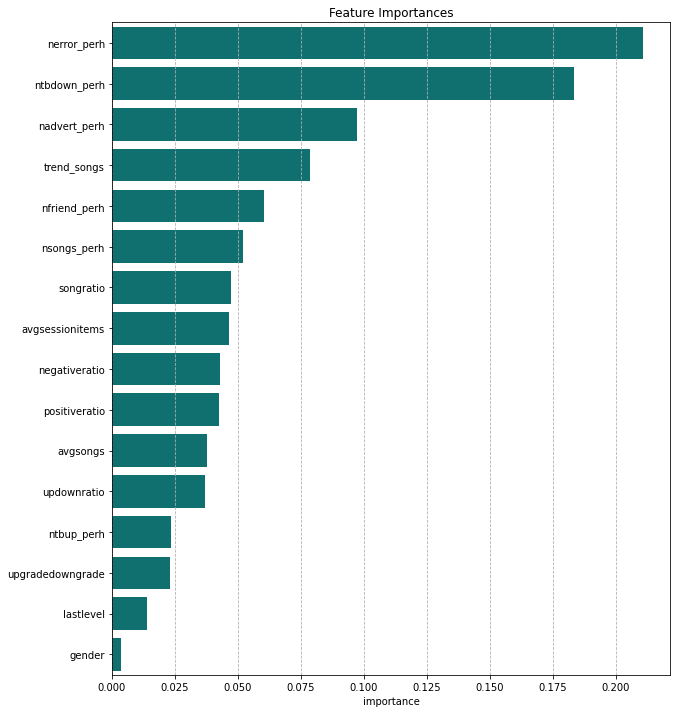

In [5]:
# Plot horizontal bar graph of features with their importances given by best estimator of RandomForestClassifier
fig, ax = plt.subplots(figsize=(10, 12),
                       nrows=1,
                       ncols=1)
features = ['lastlevel', 'gender', 'nsongs_perh', 'ntbup_perh', 'ntbdown_perh', 
            'nfriend_perh', 'nadvert_perh', 'nerror_perh', 'upgradedowngrade', 
            'songratio', 'positiveratio', 'negativeratio', 'updownratio', 
            'trend_songs', 'avgsessionitems', 'avgsongs']
importances = [0.013795342305289867, 0.003419130795754195, 0.05192724418392687, 
               0.023604481206826188, 0.18329355168409747, 0.060501586172062846, 0.0974098898402886,
               0.2110401549499677, 0.02286163968506689, 0.04730318423769473, 0.04232860002653574, 
               0.043054343894025765, 0.036773157537074976, 0.07858267078570629, 0.046534988450475566, 0.03757003424520641]
feat_imp_pd = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending = False)

# Plot
sns.barplot(data = feat_imp_pd, y = "feature", x ="importance",
           color='teal');
plt.grid(axis = 'x', linestyle = '--', zorder=0)
plt.title("Feature Importances")
plt.ylabel("");
plt.savefig('feature.png')

# 8. Conclusions

### Reflection 
Based on the good performance of the developed models, we can conclude that we have managed to build a binary classifier that can accurately identify churned users, based on the patterns in past user activity and interaction with the music streaming service. If deployed, the trained model could be used to identify users at risk of churning in advance, and help the music streaming business prevent severe financial losses.


### Potential Improvements

Despite the good performance of the developed model there is still room for further improvements:
- build and test features that capture additional insights about user's activity patterns, e.g. average length of song listening sessions, ratios of skipped or partially listened songs, etc.
- utilize song-level features that have been ignored so far, e.g. calculate the user's listening diversity in terms of different songs/artists listened to in the specified observation period, etc.
- optimize data wrangling and feature engineering steps by using Spark's best practices in order to speed up model training and testing (current solution is rather slow and does not scale well)
